# Estimate car price - Introduction to Python wrapper for SAP HANA
#### Andreas Forster
This notebook is part of a Machine Learning project that is described and available to download on 
<BR>https://blogs.sap.com/2019/11/05/hands-on-tutoria…hana-with-python/
<BR><BR>The purpose of this notebook is for you to become familiar with the most important steps to train a Machine Learning model in SAP HANA through Python. The following notebooks contain a more realistic example.

### Steps in this notebook
-  Connect to SAP HANA
-  Create a SAP HANA DataFrame which points to the data
-  Take a brief look at the data
-  Deal with missing values by ignoring all rows that are not complete
-  Train a Descision Tree in SAP HANA to estimate the price of a vehicle
-  Calculate the model's quality on the training data

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create a SAP HANA DataFrame, which points to the training data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. See the blog on the SAP Commmunity to which these notebooks belong, for steps on how to use that Secure User Store.

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(key = 'hana_hxe')

Create the SAP HANA DataFrame, which points to the table with historic sales. No data is extracted.

In [2]:
# Create the HANA dataframe in the structure of the specified table
df_pushdown = conn.table(table = 'USEDCARPRICES', schema = 'ML')

### Peek at the data and retrieve a small number of rows
Notice how no data is displayed, when calling the HANA DataFrame. You will only see the object type: hana_ml.dataframe.DataFrame. At the top of this page you find a link to the SAP HANA Python Client API documentation, where you find all details about the hana_ml package.

In [3]:
df_pushdown

To retrieve data into Python, you need to call the collect() function on the DataFrame object. In order to reduce the number of rows that are retrieved, use the head() function beforehand.

In [4]:
df_pushdown.head(3).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,16,limousine,2000,manual,160,C-Class,150000,petrol,2300
1,69,limousine,1995,manual,122,C-Class,150000,petrol,600
2,82,limousine,1996,None,150,C-Class,150000,petrol,800


### Descriptive statistics 
Display most important data column statistics. All values were calculated within SAP HANA. Notice how some columns have null values. These are rows with missing values.

In [5]:
df_pushdown.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CAR_ID,26900,26900,0,13449.500000,7765.505457,0.0,26899.0,13450.0,6724.75,6724.0,13449.5,13449.0,20174.25,20174.0
1,YEAR,26900,74,0,2003.002342,31.352877,1000.0,6200.0,2003.0,1999.00,1999.0,2003.0,2003.0,2008.00,2008.0
2,HP,26900,307,0,163.146171,212.759226,0.0,20000.0,150.0,122.00,122.0,150.0,150.0,193.00,193.0
3,KILOMETER,26900,13,0,129136.059480,36850.310066,5000.0,150000.0,150000.0,125000.00,125000.0,150000.0,150000.0,150000.00,150000.0
4,PRICE,26900,1972,0,10078.361970,86154.852061,0.0,14000500.0,6000.0,2800.00,2800.0,6000.0,6000.0,12887.25,12887.0
5,VEHICLETYPE,25899,8,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GEARBOX,26396,2,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MODEL,26381,18,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,FUELTYPE,25930,7,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot number of vehicles by model
The hana_ml package can also create a number of plots, whose underlying data was calculated within SAP HANA. For more specific requirements you can also push down further calculations to SAP HANA and retrieve the result with the collect() function as pandas data frame to create your own plot. Now display the number of vehicles by model.

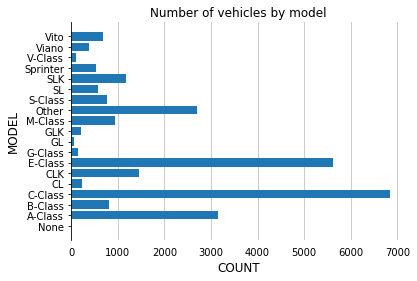

In [6]:
%matplotlib inline
from hana_ml.visualizers.eda import EDAVisualizer
import matplotlib.pyplot as plt
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
eda = EDAVisualizer(ax1)
ax, bar_data = eda.bar_plot(data = df_pushdown,
                            column = 'MODEL', 
                            aggregation = {'MODEL':'count'},
                            title = 'Number of vehicles by model')

### Drop rows with missing values 
Many algorithms require the data to be complete without missing values. Descriptive statistics above showed that various columns miss data. There are various options to deal with such missing values, ie to impute or remove the row or column. In the following notebook we will impute. In this introductory example we remove the rows with missing values from the SAP HANA Data Frame.
<BR><BR>The rows are not removed from the physical table. They are dropped from the logical construct of the SAP HANA Data Frame. Hence any process or application that might be using the underlying data is not affected.

In [7]:
df_pushdown = df_pushdown.dropna()

The SAP HANA Data Frame's SELECT statement shows how the rows with missing values were filtered out.

In [8]:
df_pushdown.select_statement

'SELECT * FROM (SELECT * FROM "ML"."USEDCARPRICES") AS "DT_0" WHERE NOT ("CAR_ID" IS NULL OR "VEHICLETYPE" IS NULL OR "YEAR" IS NULL OR "GEARBOX" IS NULL OR "HP" IS NULL OR "MODEL" IS NULL OR "KILOMETER" IS NULL OR "FUELTYPE" IS NULL OR "PRICE" IS NULL)'

### Train decision tree regression
We will train a decision tree to estimate the price. The algorithm does not support the column type INT for the target. Hence convert the PRICE column to type DOUBLE in the SAP HANA Data Frame. The data type is not changed in the physical table.

In [9]:
df_pushdown = df_pushdown.cast('PRICE', 'DOUBLE')

Train the decision tree with some hardcoded parameters. In the following notebooks we will search for parameters that lead to a stronger models. This notebook is just introducing the basic concept of training Machine Learning models within SAP HANA.

In [10]:
from hana_ml.algorithms.pal import trees
tree_reg = trees.DecisionTreeRegressor(conn_context = conn, 
                                       algorithm = 'cart',
                                       min_records_of_parent = 10,
                                       min_records_of_leaf = 2,
                                       thread_ratio = 0.4,
                                       split_threshold = 1e-5,
                                       model_format = 'json',
                                       output_rules = True)

# Specify the tree's predictors
features = ['GEARBOX', 'VEHICLETYPE', 'YEAR', 'MODEL', 'HP', 'FUELTYPE', 'KILOMETER']

# Train the tree
tree_reg.fit(data = df_pushdown, 
             key = 'CAR_ID', 
             label = 'PRICE', 
             features = features)

Once the above cell has been executed, a model has been trained. To see the DecisionTreeRegressor function's signature move the cursor into the round brackets of the function, ie place it after conn_context=conn and press SHIFT+TAB. The signature will be shown as tooltip.

## Quality metric
Calculate the model's performance on the training data. In the following notebooks, the data will be split for training and testing, leading to a more meaninful quality indicators. We calculate R^2, the coefficient of determination. 
https://en.wikipedia.org/wiki/Coefficient_of_determination

In [11]:
print('R^2 on training data: ' + str(round(tree_reg.score(data = df_pushdown, 
                                                          key = 'CAR_ID'), 3)))

R^2 on training data: 0.211


### Next

This was just a brief introduction to the concept of the Python wrapper for SAP HANA.  In the following notebooks we will create a much stronger model!